
# Project #6. Predicting the RBP-binding RNA sequences
## 20204619 Hwang Yechan
#### Link for Google Colab : https://colab.research.google.com/drive/1Az3GJ2r5jpJQhnsZSdHHCHll4txJF032?usp=sharing
<br/><br/>
### 1. Load data using google drive
In Project #6, we will upload fasta data to google drive and use them to train our model. So we will use 'drive.mount'.
<hr/>

In [1]:
# import
import os
import numpy as np
import random

import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# import my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Read fasta files
Now we can load data in set file path. Since we have two dataset, ELAVL1 and ALKBH5, I set two rbp name seperately. We can check which files are in that path. From now, I'll use postfix '_EL' as an abbreviation to express ELAVL1 and '_AL' to express ALKBH5.
<hr/>

In [3]:
# read fasta files  
fasta_file_path='gdrive/My Drive/data sample/'
rbp_name_EL = 'ELAVL1'
rbp_name_AL = 'ALKBH5'
print('list of files', os.listdir(fasta_file_path))

list of files ['ALKBH5_Baltz2012.test_negatives.fasta', 'ALKBH5_Baltz2012.test.positives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'CLIPSEQ_ELAVL1.train.positives.fasta']


### 3. Load and process dataset
We have data for training and testing seperately. First, let's load and preprocess train data. Train data consists of train dataset for ELAVL1 and ALKBH5. They have their corresponding label, positive or negative. By using list in python, we can append all their contents. Train label 1 represents its rbp sequence is positive rbp sequence and 0 is negative rbp sequence. After executing the code below, we finish preprocessing trainin data for both ELAVL1 and ALKBH5.

In [4]:
# loading training set
train_fasta_EL = list()
train_label_EL = list()

train_fasta_AL = list()
train_label_AL = list()

for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name_EL in x and 'train' in x]:
	print('Processing file...', single_file)
	with open(fasta_file_path + single_file) as f:
		for line in f.readlines():
			# get fasta sequence
			if '>' in line:
				continue
			else:
				train_fasta_EL.append(line.strip())
			# get positive negative label
			if 'positives' in single_file:
				train_label_EL.append(1)
			else:
				train_label_EL.append(0)
	
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name_AL in x and 'train' in x]:
	print('Processing file...', single_file)
	with open(fasta_file_path + single_file) as f:
		for line in f.readlines():
			# get fasta sequence
			if '>' in line:
				continue
			else:
				train_fasta_AL.append(line.strip())
			# get positive negative label
			if 'positives' in single_file:
				train_label_AL.append(1)
			else:
				train_label_AL.append(0)

Processing file... CLIPSEQ_ELAVL1.train.negatives.fasta
Processing file... CLIPSEQ_ELAVL1.train.positives.fasta
Processing file... ALKBH5_Baltz2012.train.negatives.fasta
Processing file... ALKBH5_Baltz2012.train.positives.fasta


### 4. Convert data : One-hot encoding
Using function 'convert2onehot' defined below, we can convert DNA/RNA strings to one-hot encoded array. A, U, T, G, C will be converted to 1,2,2,3,4. U and T are converted into same number since they have same context in RNA and DNA each. After converting, we have 2 arrays for input data sequence.<br/><br/>

Now, our label data have 1 dimension, each elements are 0 or 1. We can change 0 and 1 to [1,0] and [0,1] repectively using 'to_categorical' in keras.utils. Then we have 2 dimensional arrays for label.

In [5]:
# convert sequence file to one-hot encoding representation
# function: fasta to onehot representation
def convert2onehot(sequence_list):
	map = {
			'A':[1,0,0,0],
			'U':[0,1,0,0],
			'T':[0,1,0,0],
			'G':[0,0,1,0],
			'C':[0,0,0,1]
	}
	
	onehot = []
	for single_sequence in sequence_list:
		single_onehot = []
		for x in single_sequence:
			single_onehot.append(map[x.upper()])
		onehot.append(single_onehot)
		
	return np.asarray(onehot, dtype=np.float32)

train_input_EL = convert2onehot(train_fasta_EL)
train_label_EL = keras.utils.to_categorical(train_label_EL, 2)

train_input_AL = convert2onehot(train_fasta_AL)
train_label_AL = keras.utils.to_categorical(train_label_AL, 2)

We can check their shape. We have 16550 training sequences for ELAVL1 and 2361 sequences for ALKBH5. Number 4, the last element at shape, represents all bases in DNA/RNA sequence is one-hot encoded.<br/>
Because the performance of deep learning depends on the number of data, we can predict that learning ELAVL1 model will be easier.<br/><br/>

Also I checked that whether every sequences have equal lengths. We can be sure that every sequences have equal length 200 because of the result of function 'check_length' defined below.

In [6]:
train_input_EL.shape, train_input_AL.shape

((16550, 200, 4), (2361, 200, 4))

In [7]:
def check_length():
    for input in train_input_EL:
        if len(input)!=200:
            print("There is sequence whose length is not 200.")
            return 
    for input in train_input_AL:
        if len(input)!=200:
            print("There is sequence whose length is not 200.")
            return 
    print("All sequences have equal length 200.")

check_length()

All sequences have equal length 200.


### 6. Split the datasets
To avoid overfitting and train properly, it is necessary to split data into training, validation and test sets.
Since we have untouched test datasets, we only need to split train data to training set and validation set. I will use 10% of data for validation. After spliting data, we have 14895 sequences to train ELAVL1, 1655 to validate ELAVL1, 2124 to train ALKBH5 and 237 to validate ALKBH5.<br/>
To use 'train_test_split', I set 'random_state' to a random number 2. (It doesn't matter what number I put in in terms of randomness.)

In [8]:
# split training set into training set and validation set
# random shuffling of training data
from sklearn.model_selection import train_test_split

train_input_EL, validation_input_EL, train_label_EL, validation_label_EL = train_test_split(train_input_EL, train_label_EL, test_size=0.1, random_state=2)
train_input_AL, validation_input_AL, train_label_AL, validation_label_AL = train_test_split(train_input_AL, train_label_AL, test_size=0.1, random_state=2)

print('Dataset_EL preparation done... train_input_EL, train_label_EL, validation_input_EL, validation_label_EL')
print('Size of each set...', train_input_EL.shape, train_label_EL.shape, validation_input_EL.shape, validation_label_EL.shape)
print()
print('Dataset_AL preparation done... train_input_AL, train_label_AL, validation_input_AL, validation_label_AL')
print('Size of each set...', train_input_AL.shape, train_label_AL.shape, validation_input_AL.shape, validation_label_AL.shape)

Dataset_EL preparation done... train_input_EL, train_label_EL, validation_input_EL, validation_label_EL
Size of each set... (14895, 200, 4) (14895, 2) (1655, 200, 4) (1655, 2)

Dataset_AL preparation done... train_input_AL, train_label_AL, validation_input_AL, validation_label_AL
Size of each set... (2124, 200, 4) (2124, 2) (237, 200, 4) (237, 2)


In addition to dividing the data, we need to make sure that the labels are properly divided since train_label_EL and train_label_AL have 0s first and 1s second because of all negative sequences are in train.negatives.fasta which is preprocessed first and positive sequences are in train.positives.fasta which is preprocessed second. Therefor before preprocessing, labels had not shuffled sequences '000...00011....11'.<br/><br/>

First, I checked how many positive/negative rbp sequences are in our train dataset. We can check 7315 positives and 7580 negatives in ELAVL1, 1057 positives and 1067 negatives in ALKBH5. 

In [9]:
print("Distribution of 0s and 1s in train_label : ")

train_count_zero_EL=0
train_count_zero_AL=0

for i in range(len(train_label_EL)):
    if train_label_EL[i][0]==1:
        train_count_zero_EL+=1
print(str(len(train_label_EL)-train_count_zero_EL)+" positive rbp sequences in train_label_EL.")
print(str(train_count_zero_EL)+" negative rbp sequences in train_label_EL.")

for i in range(len(train_label_AL)):
    if train_label_AL[i][0]==1:
        train_count_zero_AL+=1
print(str(len(train_label_AL)-train_count_zero_AL)+" positive rbp sequences in train_label_AL.")
print(str(train_count_zero_AL)+" negative rbp sequences in train_label_AL.")

Distribution of 0s and 1s in train_label : 
7315 positive rbp sequences in train_label_EL.
7580 negative rbp sequences in train_label_EL.
1057 positive rbp sequences in train_label_AL.
1067 negative rbp sequences in train_label_AL.


Also I checked how many positive/negative rbp sequences are in our validation dataset. We can check 878 positives and 777 negatives in ELAVL1, 121 positives and 116 negatives in ALKBH5. <br/>
From these results, we can see positive and negative sequences are divided evenly.

In [10]:
print("Distribution of 0s and 1s in validation_label : ")

validation_count_zero_EL=0
validation_count_zero_AL=0

for i in range(len(validation_label_EL)):
    if validation_label_EL[i][0]==1:
        validation_count_zero_EL+=1
print(str(len(validation_label_EL)-validation_count_zero_EL)+" positive rbp sequences in validation_label_EL.")
print(str(validation_count_zero_EL)+" negative rbp sequences in validation_label_EL.")

for i in range(len(validation_label_AL)):
    if validation_label_AL[i][0]==1:
        validation_count_zero_AL+=1
print(str(len(validation_label_AL)-validation_count_zero_AL)+" positive rbp sequences in validation_label_AL.")
print(str(validation_count_zero_AL)+" negative rbp sequences in validation_label_AL.")

Distribution of 0s and 1s in validation_label : 
878 positive rbp sequences in validation_label_EL.
777 negative rbp sequences in validation_label_EL.
121 positive rbp sequences in validation_label_AL.
116 negative rbp sequences in validation_label_AL.


### 7. Build a neural network model based on CNN
I built neural networks based on CNN. Since we need two model for ELAVL1 and ALKBH5, I set hyperparameters for two architecture seperately.<br/>
Since our label data are 2 dimensional arrays, I chose 'categorical_crossentropy' for loss function. Since it is binary classification, last two layers are Dense layer with 2 dimensions and Softmax activation layer. Both of models have two Convolution layers and Pooling layers. I tried increasing them but it didn't imporve performances.

In [11]:
# model building

model_EL = tf.keras.Sequential()
model_EL.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(200, 4)))
model_EL.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_EL.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model_EL.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_EL.add(tf.keras.layers.Flatten())
model_EL.add(tf.keras.layers.Dense(128, activation='relu'))
model_EL.add(tf.keras.layers.Dropout(0.5))
model_EL.add(tf.keras.layers.Dense(2))
model_EL.add(tf.keras.layers.Softmax())

model_EL.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_EL.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 32)           416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [12]:
# model building

model_AL = tf.keras.Sequential()
model_AL.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(200, 4)))
model_AL.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_AL.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model_AL.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_AL.add(tf.keras.layers.Flatten())
model_AL.add(tf.keras.layers.Dense(64, activation='relu'))
model_AL.add(tf.keras.layers.Dropout(0.5))
model_AL.add(tf.keras.layers.Dense(2))
model_AL.add(tf.keras.layers.Softmax())

model_AL.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_AL.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 200, 32)           416       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                204864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

### 8. Train the model 
Now we are ready to train the models. In order to optimize the models, we can use early stopping watching the 
validation accuracy. We can train the models and save accuracy and loss of both training data and validation data simultaneously .



In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [14]:
# model training
# using training and validation set
epochs = 50

es_EL = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_EL = ModelCheckpoint('best_model_EL.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

hist_EL = model_EL.fit(train_input_EL, train_label_EL, validation_data=(validation_input_EL, validation_label_EL), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_EL, mc_EL])


Epoch 00001: val_accuracy improved from -inf to 0.94562, saving model to best_model_EL.h5

Epoch 00002: val_accuracy improved from 0.94562 to 0.94924, saving model to best_model_EL.h5

Epoch 00003: val_accuracy did not improve from 0.94924

Epoch 00004: val_accuracy did not improve from 0.94924

Epoch 00005: val_accuracy did not improve from 0.94924

Epoch 00006: val_accuracy did not improve from 0.94924

Epoch 00007: val_accuracy did not improve from 0.94924

Epoch 00008: val_accuracy did not improve from 0.94924
Epoch 00008: early stopping


In [15]:
es_AL = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_AL = ModelCheckpoint('best_model_AL.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

hist_AL = model_AL.fit(train_input_AL, train_label_AL, validation_data=(validation_input_AL, validation_label_AL), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AL, mc_AL])


Epoch 00001: val_accuracy improved from -inf to 0.50211, saving model to best_model_AL.h5

Epoch 00002: val_accuracy improved from 0.50211 to 0.53586, saving model to best_model_AL.h5

Epoch 00003: val_accuracy improved from 0.53586 to 0.60759, saving model to best_model_AL.h5

Epoch 00004: val_accuracy did not improve from 0.60759

Epoch 00005: val_accuracy did not improve from 0.60759

Epoch 00006: val_accuracy did not improve from 0.60759

Epoch 00007: val_accuracy improved from 0.60759 to 0.64135, saving model to best_model_AL.h5

Epoch 00008: val_accuracy did not improve from 0.64135

Epoch 00009: val_accuracy did not improve from 0.64135

Epoch 00010: val_accuracy did not improve from 0.64135
Epoch 00010: early stopping


### 9. Visualize accuracy and loss
With the stored accuracy and loss in hist_EL and hist_AL, we can visualize them using matplotlib. The code for visualizing the accuracy and loss according to epoch for model_EL and its result is shown below. And at the left plot, we can see that accuracy for validation data keep increases. At the right plot, we can see that validation loss decreases. By the two plots, we can check that our model is not overfitted.

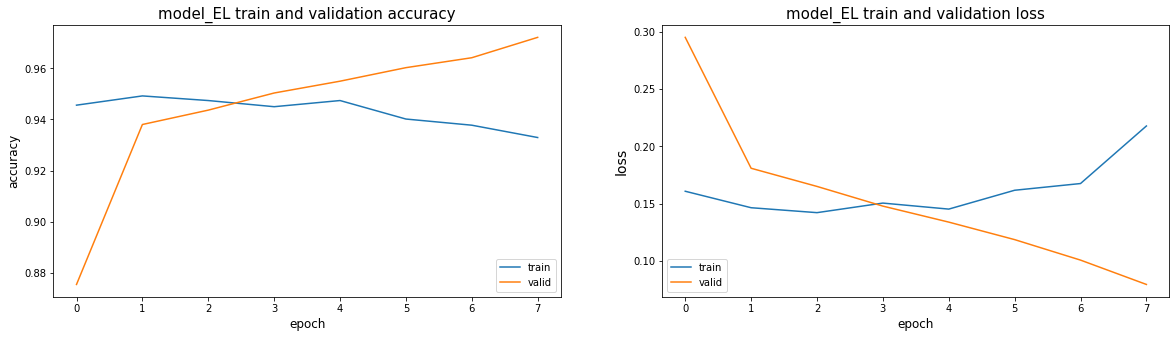

In [16]:
# plot the accuracy and loss value of each model.

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(hist_EL.history['val_accuracy'])
plt.plot(hist_EL.history['accuracy'])
plt.title('model_EL train and validation accuracy',fontsize=15)
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist_EL.history['val_loss'])
plt.plot(hist_EL.history['loss'])
plt.title('model_EL train and validation loss',fontsize=15)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower left')
plt.show()

We can do the same procedure for model_AL too. The shape of the graphs are similar to the graphs in plots above. This also shows that the model is not overfitted.<br/>
model_EL tends to finish learning earlier than model_AL since the difference of the quantity of training data.

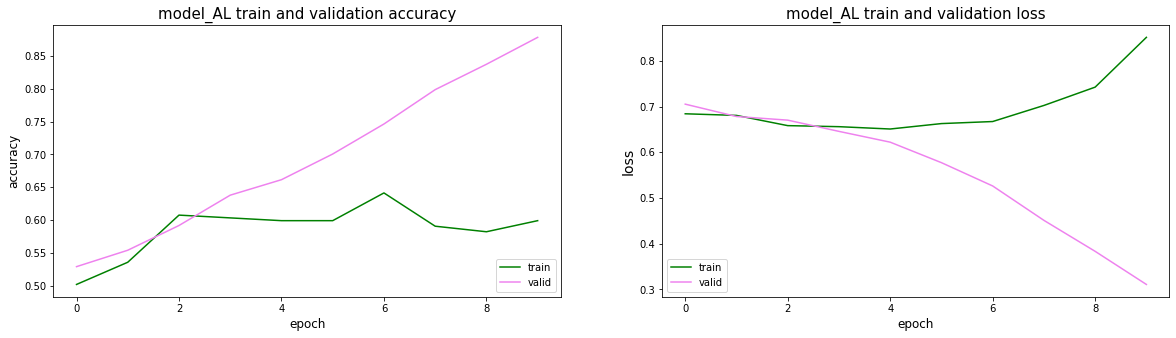

In [17]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(hist_AL.history['val_accuracy'],color='green')
plt.plot(hist_AL.history['accuracy'],color='violet')
plt.title('model_AL train and validation accuracy',fontsize=15)
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist_AL.history['val_loss'],color='green')
plt.plot(hist_AL.history['loss'],color='violet')
plt.title('model_AL train and validation loss',fontsize=15)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower left')
plt.show()

### 10. Load the best model
Now let's load the models which performed best for ELAVL1 and ALKBH5. 
I compiled them with the same parameters as when I trained them.

In [18]:
# load the best model
from keras.models import load_model
saved_model_EL = load_model('best_model_EL.h5')
saved_model_EL.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
saved_model_AL = load_model('best_model_AL.h5')
saved_model_AL.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

### 11. Evaluate the prediction model
In order to evaluate the models loaded and compiled, we have to use given test datas for EL and AL. The same procedure as in preprocessing training data was followed for test data. We can see that we have 975 sequences for testing ELAVL1 and 262 for ALKBH5.

In [19]:
# evaluation: calculate AUC score for the test set
# loading test sets 

test_fasta_EL = list()
test_label_EL = list()

test_fasta_AL = list()
test_label_AL = list()

for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name_EL in x and 'test' in x]:
	print('Processing file...', single_file)
	with open(fasta_file_path + single_file) as f:
		for line in f.readlines():
			# get fasta sequence
			if '>' in line:
				continue
			else:
				test_fasta_EL.append(line.strip())
			# get positive negative label
			if 'positives' in single_file:
				test_label_EL.append(1)
			else:
				test_label_EL.append(0)
	
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name_AL in x and 'test' in x]:
	print('Processing file...', single_file)
	with open(fasta_file_path + single_file) as f:
		for line in f.readlines():
			# get fasta sequence
			if '>' in line:
				continue
			else:
				test_fasta_AL.append(line.strip())
			# get positive negative label
			if 'positives' in single_file:
				test_label_AL.append(1)
			else:
				test_label_AL.append(0)

Processing file... CLIPSEQ_ELAVL1.test.negatives.fasta
Processing file... CLIPSEQ_ELAVL1.test.positives.fasta
Processing file... ALKBH5_Baltz2012.test_negatives.fasta
Processing file... ALKBH5_Baltz2012.test.positives.fasta


In [20]:
test_input_EL = convert2onehot(test_fasta_EL)
test_label_EL = keras.utils.to_categorical(test_label_EL, 2)

test_input_AL = convert2onehot(test_fasta_AL)
test_label_AL = keras.utils.to_categorical(test_label_AL, 2)

print('TEST_EL set prepared...', test_input_EL.shape, test_label_EL.shape)
print('TEST_AL set prepared...', test_input_AL.shape, test_label_AL.shape)

TEST_EL set prepared... (975, 200, 4) (975, 2)
TEST_AL set prepared... (262, 200, 4) (262, 2)


First we can evaluate the models by using 'classification_report'. Since I made models determining the positiveness and negativeness of rbp sequences, I set the target_names as 'negatives' and 'positives'. Then using the 'predicted classes', we can check some performances such as precision, recall, etc. Predicted class will be 1 if model's predicted probability for 1(positive) is larger than 0(negative). We can check classification_report for both ELAVL1 and ALKBH5. 

In [21]:
# evaluate the prediction model using test dataset.
from sklearn.metrics import classification_report, roc_curve, auc

true_label_EL=np.argmax(test_label_EL,axis=1)
pred_label_EL=saved_model_EL.predict_classes(test_input_EL)

target_names = ['negatives', 'positives']
print(classification_report(true_label_EL, pred_label_EL, target_names=target_names))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

   negatives       0.93      0.95      0.94       496
   positives       0.95      0.93      0.94       479

    accuracy                           0.94       975
   macro avg       0.94      0.94      0.94       975
weighted avg       0.94      0.94      0.94       975



In [22]:
true_label_AL=np.argmax(test_label_AL,axis=1)
pred_label_AL=saved_model_AL.predict_classes(test_input_AL)

target_names = ['negatives', 'positives']
print(classification_report(true_label_AL, pred_label_AL, target_names=target_names))

              precision    recall  f1-score   support

   negatives       0.65      0.65      0.65       131
   positives       0.65      0.65      0.65       131

    accuracy                           0.65       262
   macro avg       0.65      0.65      0.65       262
weighted avg       0.65      0.65      0.65       262



Also, the test score for both models is shown above. model_EL has a high accuracy over 94%.<br/>
As expected, model_EL performed better.

In [23]:
saved_model_EL.evaluate(test_input_EL, test_label_EL, verbose=2)

31/31 - 0s - loss: 0.1684 - accuracy: 0.9405


[0.16841869056224823, 0.9405128359794617]

In [24]:
saved_model_AL.evaluate(test_input_AL, test_label_AL, verbose=2)

9/9 - 0s - loss: 0.6170 - accuracy: 0.6489


[0.616963803768158, 0.6488549709320068]

This time, let's see the ROC curve and AUC of both models. Here fpr is 'False positive rates' for each possible threshold and tpr is 'True positive rates' for each possible threshold. We must give the true labels of test datasets and the predicted probabilities for the 1 class to the 'roc_curve' to calculate fpr, tpr and thresholds. (The predicted probabilities for the 1 class is second element of predicted output.) Then using fpr and tpr, we can get AUC of model_AR by using 'auc' in sklearn.<br/><br/>
We can see AUC of EL dataset is over 0.98. Also I drew plot for model_EL with blue color.

In [25]:
# calculate AUC score for test sets

# AUC of EL dataset
pred_label_EL = saved_model_EL.predict(test_input_EL)
fpr_EL, tpr_EL, thresholds_EL = roc_curve(np.argmax(test_label_EL,axis=1), pred_label_EL[:,1])
auc_EL = auc(fpr_EL, tpr_EL)
print(auc_EL)

0.980806788335915


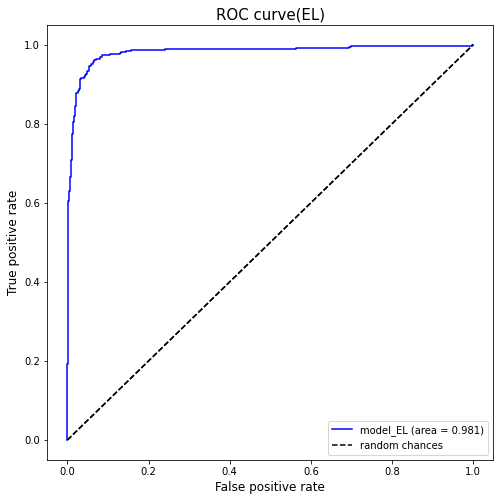

In [26]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_EL, tpr_EL, label='model_EL (area = {:.3f})'.format(auc_EL),color='blue')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve(EL)',fontsize=15)
plt.legend(loc='lower right')
plt.show()

Also we can see AUC of AL dataset is over 0.70. As expected, AUC for model_AL has worse result than model_EL. Again I drew plot for model_AL with red color.

In [27]:
# AUC of AL dataset
pred_label_AL = saved_model_AL.predict(test_input_AL)
fpr_AL, tpr_AL, thresholds_AL = roc_curve(np.argmax(test_label_AL,axis=1), pred_label_AL[:,1])
auc_AL = auc(fpr_AL, tpr_AL)
print(auc_AL)

0.7151098420837946


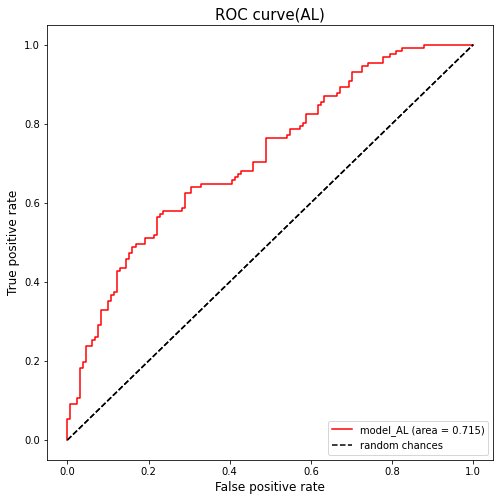

In [28]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_AL, tpr_AL, label='model_AL (area = {:.3f})'.format(auc_AL),color='red')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve(AL)',fontsize=15)
plt.legend(loc='lower right')
plt.show()

Finally, I drew the two ROC curves overlapping and finished the project.

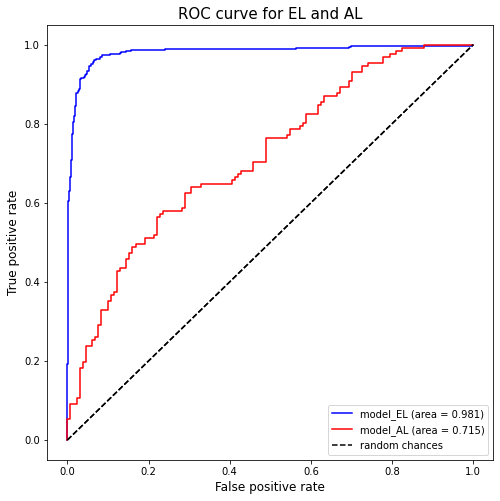

In [29]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_EL, tpr_EL, label='model_EL (area = {:.3f})'.format(auc_EL),color='blue')
plt.plot(fpr_AL, tpr_AL, label='model_AL (area = {:.3f})'.format(auc_AL),color='red')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve for EL and AL',fontsize=15)
plt.legend(loc='lower right')
plt.show()